## Importing All Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import time
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
%matplotlib inline

## Importing Dataset i.e. Nabil Bank (nabil) Stock Price Dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/MSc. Dissertation/Dataset/nabil.csv')

In [3]:
df.head()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
0,3/20/2011,"1,200.00","1,190.00","1,160.00","1,170.00",0.0,853,"1,000,811.00"
1,3/24/2011,"1,162.00","1,178.00","1,150.00","1,153.00",0.0,356,"412,649.00"
2,3/25/2011,"1,153.00","1,174.00","1,145.00","1,174.00",0.0,702,"807,507.00"
3,3/27/2011,"1,174.00","1,160.00","1,120.00","1,147.00",0.0,"1,426.00","1,619,270.00"
4,3/28/2011,"1,147.00","1,150.00","1,110.00","1,132.00",0.0,352,"393,534.00"


In [4]:
df.tail()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
3078,9/18/2024,562,565,550,556,-0.93,"68,886.00","38,431,118.40"
3079,9/22/2024,556,578,556,562,1.08,"55,026.00","31,054,968.70"
3080,9/23/2024,573.2,573.2,555,568,1.07,"123,568.00","69,577,465.00"
3081,9/24/2024,567,567,552.1,553.5,-2.55,"66,337.00","36,962,336.00"
3082,9/25/2024,550,560,545.1,555,0.27,"50,441.00","27,867,328.70"


In [5]:
df.duplicated().sum()

1

## Copying the dataset for future use

In [6]:
df1 = df.copy()
df1.reset_index(inplace=True)

### Dropping unwanted column

In [7]:
df.drop(['% Change', 'Turnover'], axis=1, inplace=True)
df = df.rename(columns = {
    'Ltp': 'Close',
    'Qty': 'Volume'
})

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float).astype(int)
df

,Date,Open,High,Low,Close,Volume
0,2011-03-20,1200.0,1190.0,1160.0,1170.0,853
1,2011-03-24,1162.0,1178.0,1150.0,1153.0,356
2,2011-03-25,1153.0,1174.0,1145.0,1174.0,702
3,2011-03-27,1174.0,1160.0,1120.0,1147.0,1426
4,2011-03-28,1147.0,1150.0,1110.0,1132.0,352
...,...,...,...,...,...,...
3078,2024-09-18,562.0,565.0,550.0,556.0,68886
3079,2024-09-22,556.0,578.0,556.0,562.0,55026
3080,2024-09-23,573.2,573.2,555.0,568.0,123568
3081,2024-09-24,567.0,567.0,552.1,553.5,66337


### Splitting into features and target

In [9]:
features = df[['Open', 'High', 'Low', 'Volume']]
target = df[['Close']]

### Scaling the features

In [10]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale the features (Open, High, Low, Volume)
scaled_features = scaler_features.fit_transform(features)

# Scale the target (Close)
scaled_target = scaler_target.fit_transform(target)

### Convert to DataFrame to maintain indices

In [11]:
# Combine the scaled features and scaled target into a new DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=['Open', 'High', 'Low', 'Volume'])
scaled_data['Close'] = scaled_target  # Use the scaled Close values as the target

### Function to create sequences

In [12]:
sequence_length = 60
X = []
y = []
target_index = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[['Open', 'High', 'Low', 'Volume']].values[i-sequence_length:i])
    y.append(scaled_data['Close'].values[i])
    target_index.append(i)  # store index of each target value

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

### Splitting the data into train and test set

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, y_test_indices = train_test_split(target_index, test_size=0.2, random_state=42)

# X_train, X_test, y_train, y_test = X[:round(X.shape[0]*0.8)], X[round(X.shape[0]*0.8):], y[:round(y.shape[0]*0.8)], y[round(y.shape[0]*0.8):]
# _, y_test_indices = target_index[:round(len(target_index)*0.8)], target_index[round(len(target_index)*0.8):]

### Model Building using CNN

In [14]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    LSTM(50),
    Dense(25),
    Dense(1)  # Single output for regression
])

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# 4. Train the Model
start = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)
end = time.time()
print('Training Time: ', end-start)

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 114ms/step - loss: 0.0172 - mae: 0.0755 - mse: 0.0172 - val_loss: 0.0016 - val_mae: 0.0249 - val_mse: 0.0016
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - loss: 0.0016 - mae: 0.0258 - mse: 0.0016 - val_loss: 0.0028 - val_mae: 0.0411 - val_mse: 0.0028
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - loss: 0.0016 - mae: 0.0253 - mse: 0.0016 - val_loss: 0.0011 - val_mae: 0.0240 - val_mse: 0.0011
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - loss: 0.0011 - mae: 0.0215 - mse: 0.0011 - val_loss: 0.0012 - val_mae: 0.0234 - val_mse: 0.0012
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - loss: 0.0012 - mae: 0.0210 - mse: 0.0012 - val_loss: 0.0011 - val_mae: 0.0215 - val_mse: 0.0011
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - loss: 0.0010 - mae: 0.0201 - mse: 0.0010 - val_loss: 9.5278e-04 - val_mae: 0.0221 - val_mse: 9.5278e-04
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - loss: 7.9218e-04 

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          23,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 425,417 (1.62 MB)

 Trainable params: 141,805 (553.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 283,612 (1.08 MB)

In [17]:
# Make predictions on the test set
predictions = model.predict(X_test)
predictions.flatten()

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


array([0.07420822, 0.18438278, 0.4925215 , 0.3461198 , 0.22107662,
       0.5929529 , 0.209142  , 0.33176368, 0.8524659 , 0.08656008,
       0.77956885, 0.7980225 , 0.3180944 , 0.1310254 , 0.46602887,
       0.62212634, 0.5455396 , 0.24685709, 0.5438811 , 0.5702619 ,
       0.86180365, 0.69867474, 0.21388496, 0.43080556, 0.65308934,
       0.7864799 , 0.8448034 , 0.17033966, 0.4598144 , 0.22251995,
       0.39093223, 0.4588237 , 0.16292025, 0.17602524, 0.06838331,
       0.10919289, 0.11401325, 0.37402654, 0.12256914, 0.1604507 ,
       0.5068981 , 0.24604852, 0.16076152, 0.18729974, 0.5811862 ,
       0.15643206, 0.48030424, 0.27010182, 0.22003604, 0.13604659,
       0.07787719, 0.45511472, 0.664455  , 0.821335  , 0.47526672,
       0.3894429 , 0.15287523, 0.02224406, 0.38193128, 0.78264034,
       0.03393406, 0.05317576, 0.64841604, 0.03445413, 0.45629275,
       0.19203018, 0.48222682, 0.0779994 , 0.0502447 , 0.17271705,
       0.16597587, 0.2935431 , 0.39966556, 0.25817865, 0.19290

In [18]:
y_test

array([0.05979381, 0.17525773, 0.4871134 , 0.34278351, 0.20532646,
       0.56829897, 0.19458763, 0.32560137, 0.84106529, 0.08457904,
       0.80670103, 0.78135739, 0.30030069, 0.12328179, 0.45661512,
       0.62414089, 0.52749141, 0.22852234, 0.53393471, 0.55584192,
       0.86039519, 0.68298969, 0.22036082, 0.42869416, 0.6387457 ,
       0.74226804, 0.8024055 , 0.16237113, 0.45489691, 0.21821306,
       0.41408935, 0.44372852, 0.15292096, 0.17310997, 0.06013746,
       0.09755155, 0.10910653, 0.34879725, 0.1121134 , 0.14690722,
       0.48883162, 0.23539519, 0.14948454, 0.1911512 , 0.5661512 ,
       0.14862543, 0.47594502, 0.24828179, 0.20614261, 0.13316151,
       0.07216495, 0.44630584, 0.64991409, 0.7637457 , 0.46219931,
       0.38230241, 0.14213918, 0.00987973, 0.29381443, 0.74226804,
       0.02792096, 0.04252577, 0.62843643, 0.02276632, 0.45446735,
       0.1838488 , 0.47293814, 0.06958763, 0.03994845, 0.15592784,
       0.1621134 , 0.27491409, 0.36984536, 0.25167526, 0.18384

In [19]:
y_pred_inv = scaler_target.inverse_transform(predictions)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

In [20]:
prediction = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': y_pred_inv.flatten()}, index=y_test_indices)
for a in prediction.index:
    for b in df.index:
        if a == b:
            prediction['Date'] = df['Date']
prediction.set_index('Date', inplace=True)
prediction.sort_index(inplace=True)
prediction

,Actual,Predicted
Date,,
2011-06-27,1106.0,1311.135986
2011-07-07,1120.0,1154.565918
2011-07-18,1283.0,1352.421387
2011-07-28,1289.0,1296.646362
2011-08-10,1234.0,1231.040161
...,...,...
2024-09-10,569.8,605.121704
2024-09-11,561.5,597.724060
2024-09-16,561.2,594.756714


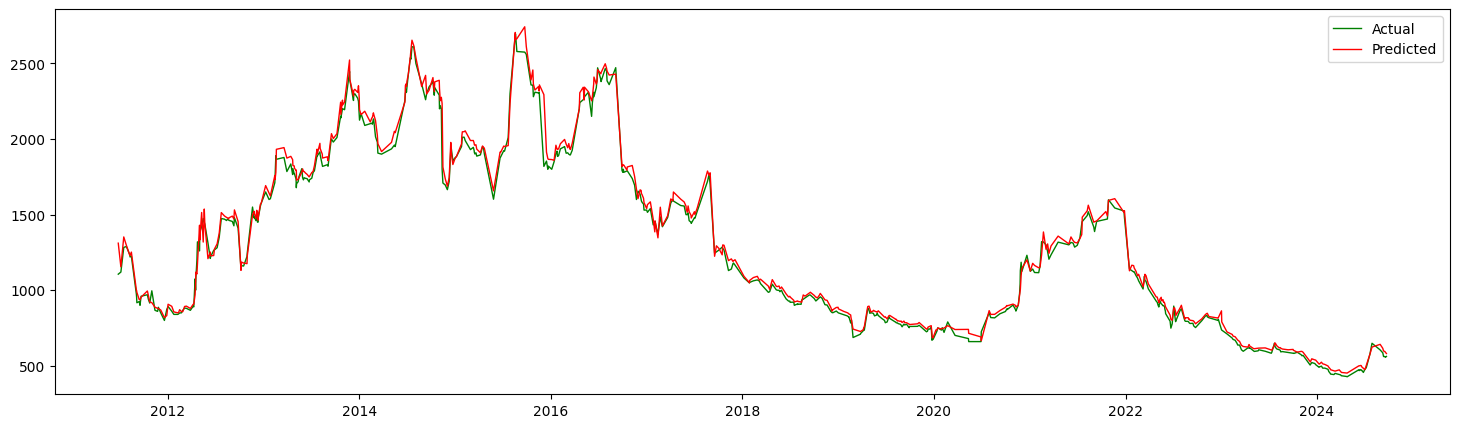

In [21]:
plt.figure(figsize=(18, 5))
plt.plot(prediction.Actual, label='Actual', color='g', linewidth=1)
plt.plot(prediction.Predicted, label='Predicted', color='r', linewidth=1)
plt.legend()
plt.show()


## Calculating the Performance Evaluation Metrics

In [22]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 0.00046773814656203165
Root Mean Squared Error: 0.021627254716260952
Mean Absolute Error: 0.015131772567809891


In [23]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 2534.9464521379987
Root Mean Squared Error: 50.34825172871446
Mean Absolute Error: 35.22676746715198
